In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Question 1: Propensity Score Matching

In [52]:
data = pd.read_csv('lalonde.csv', dtype={
    'treat': np.bool_,
    'age': np.uint8,
    'age': np.uint8,
    'nodegree': np.bool_,
    'married': np.bool_,
    'black': np.bool_,
    'hispan': np.bool_,
    're74': np.float32,
    're75': np.float32,
    're78': np.float32
})

In [53]:
data.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,NSW1,True,37,11,True,False,True,True,0.0,0.0,9930.045898
1,NSW2,True,22,9,False,True,False,True,0.0,0.0,3595.894043
2,NSW3,True,30,12,True,False,False,False,0.0,0.0,24909.449219
3,NSW4,True,27,11,True,False,False,True,0.0,0.0,7506.145996
4,NSW5,True,33,8,True,False,False,True,0.0,0.0,289.789886


## 1 - A naive analysis

In [54]:
treated = data.re78[data.treat == True]

In [55]:
treated.describe()

count      185.000000
mean      6349.145508
std       7867.402344
min          0.000000
25%        485.229797
50%       4232.309082
75%       9642.999023
max      60307.929688
Name: re78, dtype: float64

In [56]:
not_treated = data.re78[data.treat == False]

In [57]:
not_treated.describe()

count      429.000000
mean      6984.169434
std       7294.164551
min          0.000000
25%        220.181305
50%       4975.504883
75%      11688.820312
max      25564.669922
Name: re78, dtype: float64

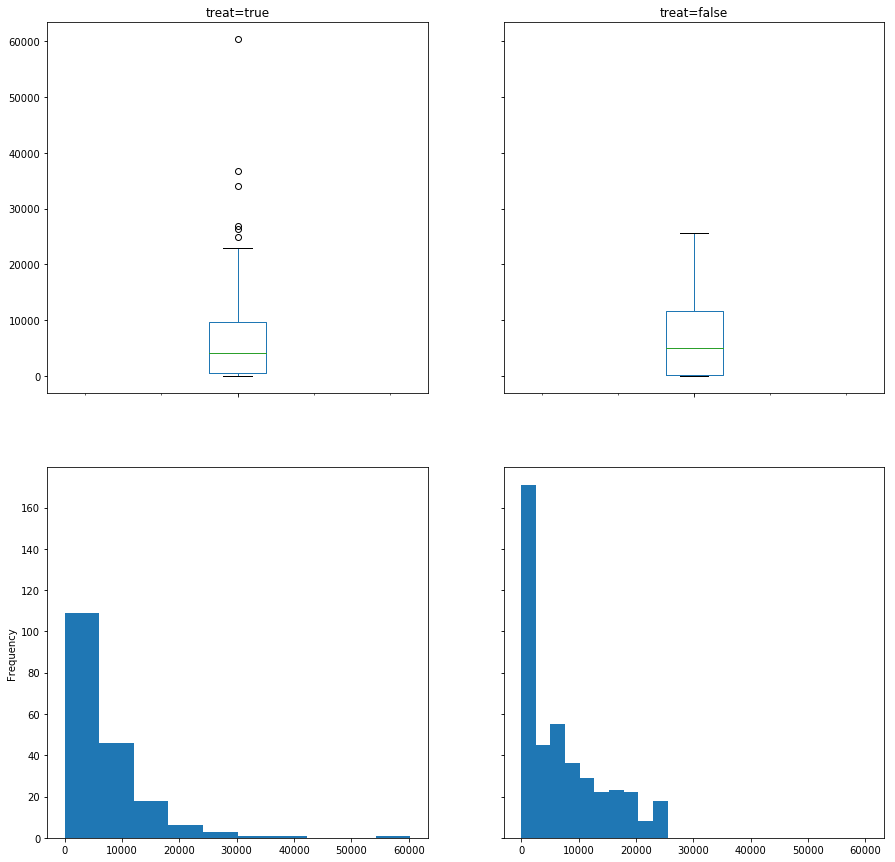

In [71]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, sharey='row', sharex='row', figsize=(15, 15))

treated.plot.box(ax=ax1)
not_treated.plot.box(ax=ax2)
ax1.set_title('treat=true')
ax2.set_title('treat=false')

treated.plot.hist(ax=ax3)
not_treated.plot.hist(ax=ax4)